## Accelerating Metal-Organic Framework Discovery via Synthesisability Prediction: The MFD Evaluation Method for One-Class Classification Models

Chi Zhang, Dmytro Antypov, Matthew J. Rosseinsky, and Matthew S. Dyer*<br/>
Email: M.S.Dyer@liverpool.ac.uk <br/>

Please cite the corresponding paper if you use the Maximum Fractional Difference (MFD) method or these trained machine learning (ML) models in your work.<br/>

The Jupyter Notebook hereafter presents the training procedure (corresponding to Figure 1, step 4) of one-class classification models. To avoid repetition, this notebook shows only seven OCC models (IForest, kNN, OCSVM, LOF, CBLOF, LUNAR, and DeepSVDD) trained by their best-performing feature sets. 

This notebook requires the following input files from the `dataset_generation_and_featurization` folder:

`ground_truth_pairs.csv` - the list of metal and linker combinations of the ground_truth dataset<br/>
`query_pairs.csv` - the list of metal and linker combinations of the query dataset<br/>
`linker_list.pkl` - the list of linkers<br/>
`metal_scaled_205.csv` - the list of normalised 205 metal features<br/>

This notebook outputs the following files:

`MorganFP_256_train.csv` - the prediction results of five traditional models (IForest, kNN, OCSVM, LOF, CBLOF) for the ground_truth dataset<br/>
`MorganFP_256_test.csv` - the prediction results of five traditional models (IForest, kNN, OCSVM, LOF, CBLOF) for the query dataset<br/>
`DeepSVDD_train.csv` - the prediction results of the DeepSVDD model for the ground_truth dataset<br/>
`DeepSVDD_test.csv` - the prediction results of the DeepSVDD model for the query dataset<br/>
`Lunar_train.csv` - the prediction results of the LUNAR model for the ground_truth dataset<br/>
`Lunar_test.csv` - the prediction results of the LUNAR model for the query dataset<br/>

This folder also includes the following file(s):

`Classifiers_Hyperparameter.txt` - optimised hyperparameters for traditional models with different feature sets

In [1]:
#import libraries
import pandas as pd
import numpy as np

#from sklearn.preprocessing import scaler Methods
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
from matplotlib import cm
import itertools
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn import datasets, metrics
from numpy import nan as NaN

In [2]:
#import the ground_truth dataset and the query dataset
labelled_pairs = pd.read_csv('../dataset_generation_and_featurization/ground_truth_pairs.csv', index_col=0)
unlabelled_pairs = pd.read_csv('../dataset_generation_and_featurization/query_pairs.csv', index_col=0)

# Traditional models trained by 205 metal features and 256-dimensional ECFPs

In [3]:
#function for training models and making predictions
def fit_predict(clf, X_train, X_test):
    
    train_scores = []
    test_scores = []
    clf.fit(X_train)

    train_scores = clf.decision_function(X_train) # higher scores represent outliers
    test_scores = clf.decision_function(X_test)
    train_scores = train_scores *(-1)  # higher scores represent inliers
    test_scores = test_scores *(-1)
    train_pred = clf.predict(X_train)  # 0-inliers; 1-outliers
    test_pred  = clf.predict(X_test)

    return train_scores, test_scores

In [5]:
import pyod
from pyod.models.knn import KNN
from joblib import dump, load

import pickle
with open('../dataset_generation_and_featurization/linker_list.pkl','rb') as f:
    linker_list = pickle.load(f)
print(len(linker_list)) 

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

#import 205 metal features
metal_minmax = pd.read_csv('../dataset_generation_and_featurization/metal_scaled_205.csv',index_col=0)

#build empty dataframe to save results
train_result=pd.DataFrame()
test_result=pd.DataFrame()
    
#ECFPs features generation for all linkers
def morgan_fpts_dl(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = AllChem.GetMorganFingerprintAsBitVect(mol,2,256)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)
    return np.array(Morgan_fpts)

Morgan_fpts_dl = morgan_fpts_dl(linker_list)
linker_minmax = pd.DataFrame(Morgan_fpts_dl, index=linker_list, columns=['Col_{}'.format(i) for i in range(Morgan_fpts_dl.shape[1])])

#generate full data vector
#ground_truth dataset
metal_data= list()
for metal in labelled_pairs['metal']:
    metal_data.append(metal_minmax.loc[metal,:])    
metal_data = pd.DataFrame(metal_data, index=np.arange(len(labelled_pairs['metal'])), columns = metal_minmax.columns.values)
linker_data= list()
for linker in labelled_pairs['linker_SMILES']:   
    linker_data.append(linker_minmax.loc[linker,:])
linker_data = pd.DataFrame(linker_data, index=np.arange(len(labelled_pairs['metal'])), columns= linker_minmax.columns.values)
labelled_df = pd.concat([labelled_pairs, metal_data, linker_data], axis = 1)
#query dataset
metal_data= list()
for metal in unlabelled_pairs['metal']:
    metal_data.append(metal_minmax.loc[metal,:])    
metal_data = pd.DataFrame(metal_data, index=np.arange(len(unlabelled_pairs['metal'])), columns = metal_minmax.columns.values)
linker_data= list()
for linker in unlabelled_pairs['linker_SMILES']:   
    linker_data.append(linker_minmax.loc[linker,:])
linker_data = pd.DataFrame(linker_data, index=np.arange(len(unlabelled_pairs['metal'])), columns= linker_minmax.columns.values)
unlabelled_df = pd.concat([unlabelled_pairs, metal_data, linker_data], axis = 1)

#training data and test data assignment
X_train = labelled_df.iloc[:,2:] 
X_test = unlabelled_df.iloc[:,2:]

#import the standard one class models
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.cblof import CBLOF

classifiers = {  
    'IForest': 
        IForest(behaviour="new", bootstrap=False, contamination=0.1, n_estimators=300,  max_features=1.0, max_samples=1000, random_state=None),  
    'CBLOF':    
        CBLOF(contamination=0.1, alpha=0.6, beta=2, n_clusters=32, n_jobs=None),
    'OCSVM': 
        OCSVM(contamination=0.1, kernel='rbf' , nu= 0.8, degree=10, gamma='auto', shrinking=True, tol=0.001, cache_size=200), 
    'KNN': 
        KNN(contamination=0.1, method='mean', n_neighbors=150, metric='minkowski', algorithm='auto'),    
    'LOF':
        LOF(algorithm='auto', n_neighbors=27, contamination=0.1, novelty=True, metric='minkowski'), 
}

#train models
for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    train_scores, test_scores = fit_predict(clf, X_train, X_test)
    #record raw scores without normalisation
    train_result.insert(train_result.shape[1],column=clf_name,value=train_scores)
    test_result.insert(test_result.shape[1],column=clf_name,value=test_scores)

#save results
train_result.to_csv('MorganFP_256_train.csv')
test_result.to_csv('MorganFP_256_test.csv')

,IForest,KNN,OCSVM,LOF,CBLOF
0,0.066527,-4.082971,36.150763,-1.039950,-3.121181
1,0.025113,-5.267552,-115.261955,-1.037974,-4.661301
2,0.051346,-4.261344,-18.580294,-1.078928,-3.433862
3,0.031443,-5.035627,-81.673603,-1.130457,-4.239535
4,0.052991,-4.346504,-14.526514,-1.064292,-3.415191
...,...,...,...,...,...
161833,-0.007235,-5.828477,-94.677013,-1.345319,-5.391080
161834,-0.011295,-5.897004,-119.427183,-1.249328,-5.231587
161835,-0.005086,-5.503974,-100.112239,-1.469179,-5.189336
161836,-0.043329,-6.569885,-208.120266,-1.414922,-6.074670


In [9]:
#read results
train_result = pd.read_csv('MorganFP_256_train.csv', index_col=0)
test_result = pd.read_csv('MorganFP_256_test.csv', index_col=0)

#plot score distributions & positive fraction distributions in the following sequence
i_index = list(train_result.columns.values)
i_index_modi = ['IForest', 'KNN', 'OCSVM', 'LOF', 'CBLOF']
i_index

['IForest', 'KNN', 'OCSVM', 'LOF', 'CBLOF']

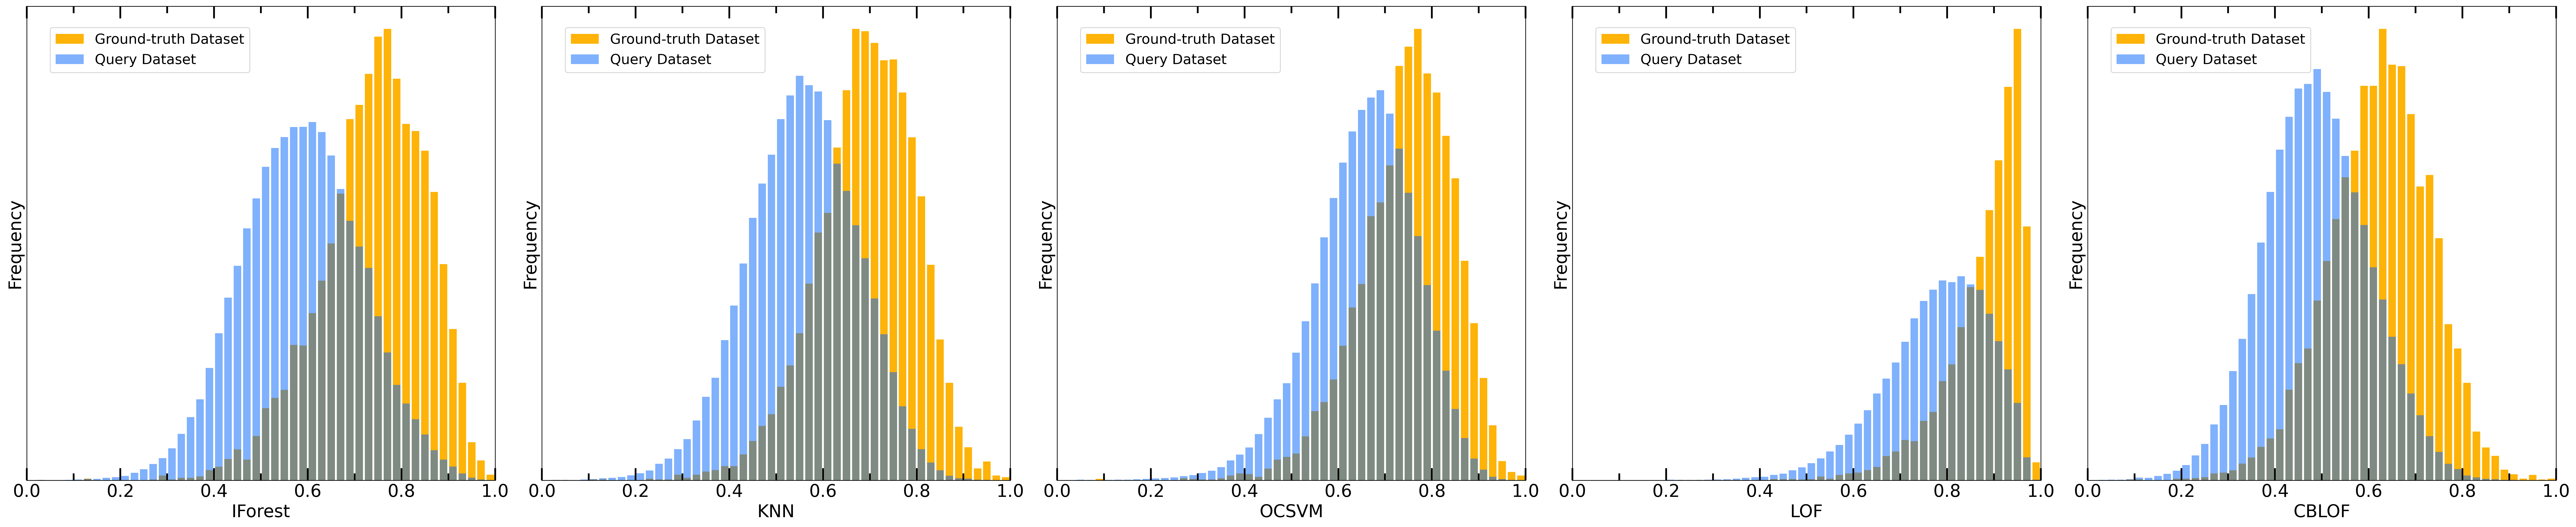

In [10]:
MinMax_scaler = preprocessing.MinMaxScaler()

#plot score distributions
%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(52,10),dpi=300)

for key in i_index_modi:
    #score normalisation
    scores_range = np.concatenate((train_result.loc[:,key],test_result.loc[:,key])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_result.loc[:,key]).reshape(-1,1)) 
    test_scores = scores_scaler.transform(np.array(test_result.loc[:,key]).reshape(-1,1))
    scores_bins = scores_scaler.transform(scores_range)
    
    ax = plt.subplot(1,5,i_index_modi.index(key)+1)
    _, bins , _ = plt.hist(scores_bins, bins=50, density=True, rwidth=0, alpha=0)
    plt.hist(train_scores, bins=bins, rwidth=0.8, histtype='bar', density=True, alpha=1, color='#feb308', label='Ground-truth Dataset')
    _= plt.hist(test_scores[:], bins=bins, density=True, rwidth=0.8, alpha=0.5, color='#0165fc', label='Query Dataset')
    
    figure_label = str(key)
    plt.grid(False)
    plt.xlim(0, 1.0)
    plt.xlabel(figure_label, fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks([])
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    major_ticks_x = np.arange(0, 1.001, 0.2)
    minor_ticks_x = np.arange(0,1.001, 0.1)
    ax.tick_params(axis = 'both', which='both', width=2)
    ax.tick_params(axis = 'both', which='major', length=14)
    ax.tick_params(axis = 'both', which='minor', length=8, color='black')
    ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)

    plt.legend(prop={'size': 16}, loc=[0.05, 0.86])
    
plt.subplots_adjust(wspace=0.1)
plt.show()

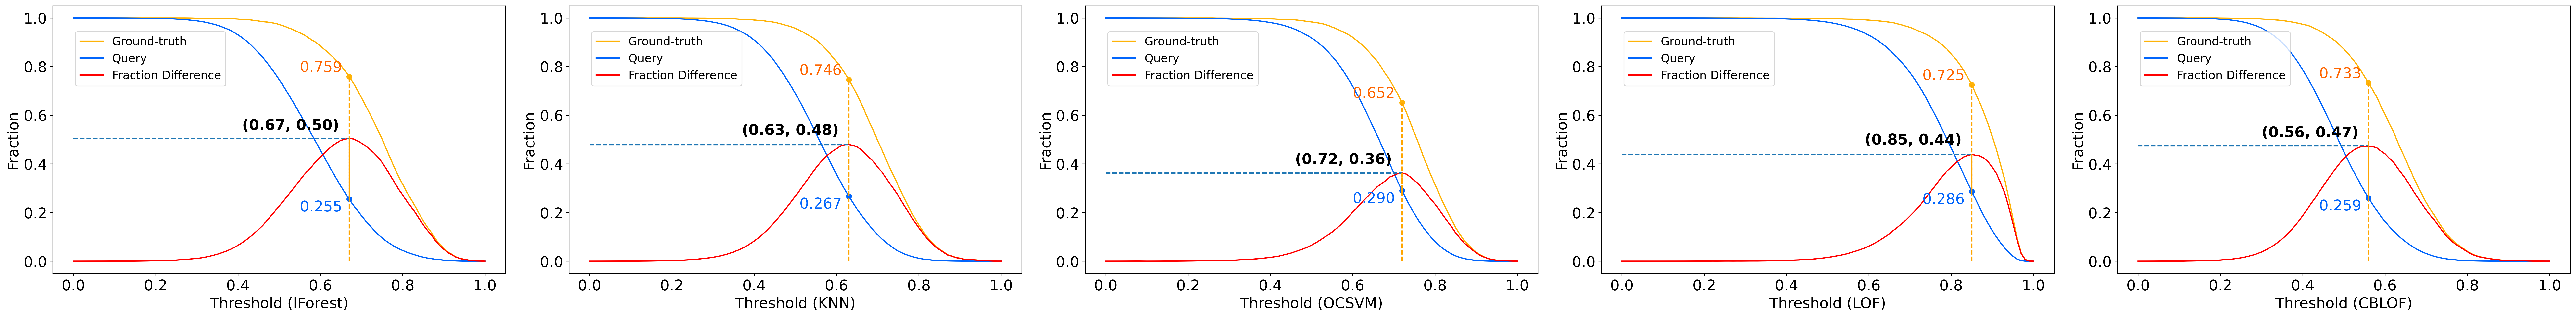

In [11]:
MinMax_scaler = preprocessing.MinMaxScaler()

#plot positive fraction distributions
%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(55,6),dpi=300)

for key in i_index_modi:
    
    #score normalisation
    scores_range = np.concatenate((train_result.loc[:,key],test_result.loc[:,key])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_result.loc[:,key]).reshape(-1,1)) 
    test_scores = scores_scaler.transform(np.array(test_result.loc[:,key]).reshape(-1,1))
    
    ax = plt.subplot(1,5,i_index_modi.index(key)+1)
    fontsize = 18
    
    #set 100 thresholds between [0,1] 
    iter_num = np.linspace(0.0,1.0,num=101)
    train_fraction = []
    test_fraction = []
    single_eval = []
    
    for i in iter_num:
        threshold = i
        train_count_inlier = np.sum(train_scores >= threshold)
        test_count_inlier = np.sum(test_scores[:] >= threshold)
        train_percent = train_count_inlier/7391
        test_percent = test_count_inlier/161838
        single = train_percent - test_percent
        train_fraction.append(train_percent)
        test_fraction.append(test_percent)
        single_eval.append(single)

    #plot positive fraction distributions for the ground_truth and the query dataset, and the fraction difference between these two datasets
    plt.plot(iter_num,train_fraction,color='#feb308',label='Ground-truth')
    plt.plot(iter_num,test_fraction,color='#0165fc',label='Query')
    plt.plot(iter_num,single_eval,color='red',label='Fraction Difference')
    
    #extreme point calculation and labelling
    single_max = max(single_eval)
    temp = single_eval.index(single_max)
    threshold_max = iter_num[temp]
    plt.plot([0,threshold_max],[single_max,single_max], '--')
    plt.plot([threshold_max,threshold_max],[0,single_max], '--', color='orange')
    single_max = round(single_max,2)
    cord =  '('+format(threshold_max, '.2f')+', '+format(single_max,'.2f')+')'
    plt.text(threshold_max-0.26, single_max+0.04, cord, fontsize=fontsize, fontweight='semibold')
    #the positive fraction for the query dataset at the extreme point
    test_max = test_fraction[temp]
    test_max = round(test_max,3)
    plt.scatter(threshold_max, test_max, c='#0165fc')
    plt.text(threshold_max-0.12, test_max-0.05, format(test_max,'.3f'), fontsize=fontsize,c='#0165fc')
    #the positive fraction for the ground_truth dataset at the extreme point
    train_max = train_fraction[temp]
    train_max = round(train_max,3)
    plt.scatter(threshold_max, train_max, c='#feb308')
    plt.text(threshold_max-0.12, train_max+0.02, format(train_max,'.3f'), fontsize=fontsize,c='#ff6600')
    #draw reference line
    refer_min, refer_max = min(train_max, test_max), max(train_max, test_max)
    plt.plot([threshold_max,threshold_max],[refer_min,refer_max], '--', color='orange')
    
    label = 'Threshold ('+key+')'
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(label, fontsize=fontsize)
    plt.ylabel('Fraction', fontsize=fontsize)
    plt.legend(prop={'size': 14}, loc=[0.05, 0.70])
    
plt.subplots_adjust(wspace=0.14)    
plt.show()

# LUNAR model trained by 205 metal features and 256-dimensional ECFPs 

In [ ]:
%cd ../models
from pyod_modi.models.lunar_2 import LUNAR

#build empty dataframe to save results
train_result=pd.DataFrame()
test_result=pd.DataFrame()

#train models and make predictions 
clf_lunar = LUNAR(verbose=1, n_epochs=100)    
train_scores, test_scores = fit_predict(clf_lunar, X_train, X_test)

#record scores without normalization
train_result.insert(train_result.shape[1],column='2',value=train_scores)
test_result.insert(test_result.shape[1],column='2',value=test_scores)

#save results
train_result.to_csv('Lunar_train.csv')
test_result.to_csv('Lunar_test.csv')

In [22]:
#read results
train_result = pd.read_csv('Lunar_train.csv', index_col=0)
test_result = pd.read_csv('Lunar_test.csv', index_col=0)

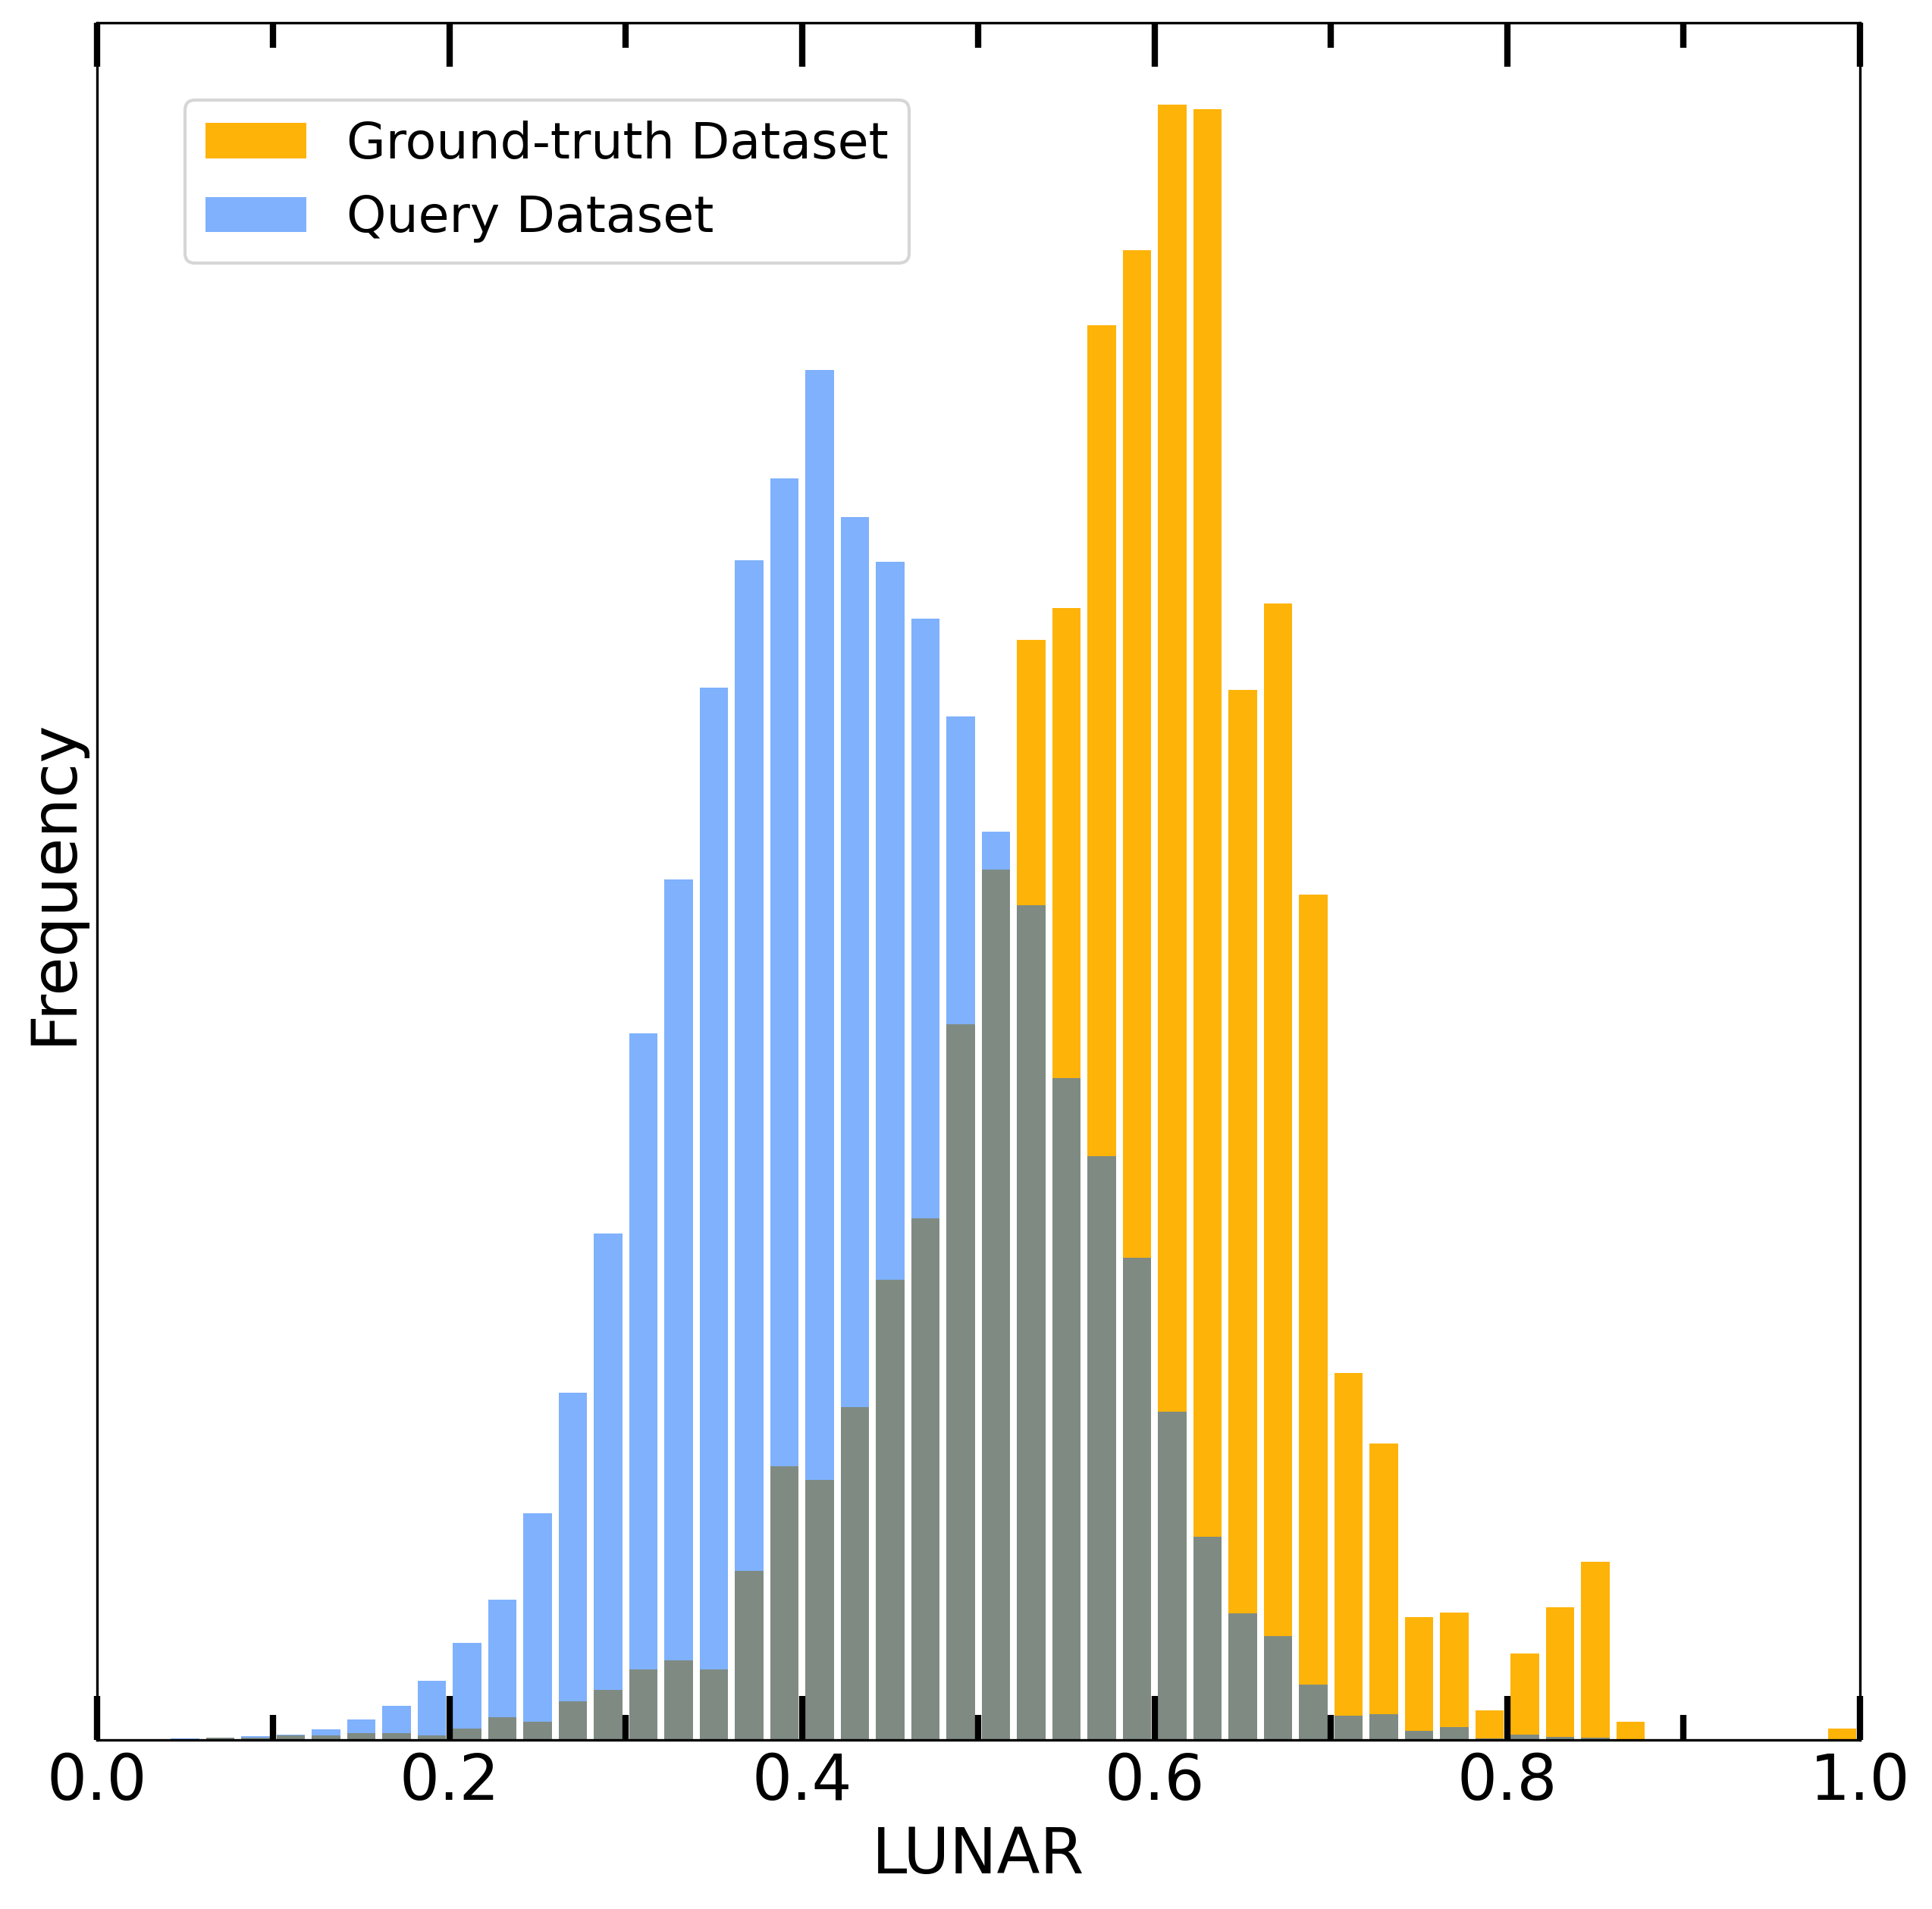

In [27]:
#plot score distributions
MinMax_scaler = preprocessing.MinMaxScaler()

%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,10),dpi=300)

for i in np.arange(1):
    #score normalisation
    scores_range = np.concatenate((train_result.iloc[:,i],test_result.iloc[:,i])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_result.iloc[:,i]).reshape(-1,1)) 
    test_scores = scores_scaler.transform(np.array(test_result.iloc[:,i]).reshape(-1,1))
    scores_bins = scores_scaler.transform(scores_range)
    
    ax = plt.subplot(1,1,i+1)
    _, bins , _ = plt.hist(scores_bins, bins=50, density=True, rwidth=0, alpha=0)
    plt.hist(train_scores, bins=bins, rwidth=0.8, histtype='bar', density=True, alpha=1, color='#feb308', label='Ground-truth Dataset')
    _= plt.hist(test_scores[:], bins=bins, density=True, rwidth=0.8, alpha=0.5, color='#0165fc', label='Query Dataset')
    #_ = plt.axvline(x=threshold, label='Threshold',linestyle='--', c='r', linewidth=3) # threshold line   

    plt.grid(False)
    plt.xlim(0, 1.0)
    plt.xlabel('LUNAR', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks([])
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    major_ticks_x = np.arange(0, 1.001, 0.2)
    minor_ticks_x = np.arange(0,1.001, 0.1)
    ax.tick_params(axis = 'both', which='both', width=2)
    ax.tick_params(axis = 'both', which='major', length=14)
    ax.tick_params(axis = 'both', which='minor', length=8, color='black')
    ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)

    plt.legend(prop={'size': 16}, loc=[0.05, 0.86])
   
plt.subplots_adjust(wspace=0.1)
plt.show()  

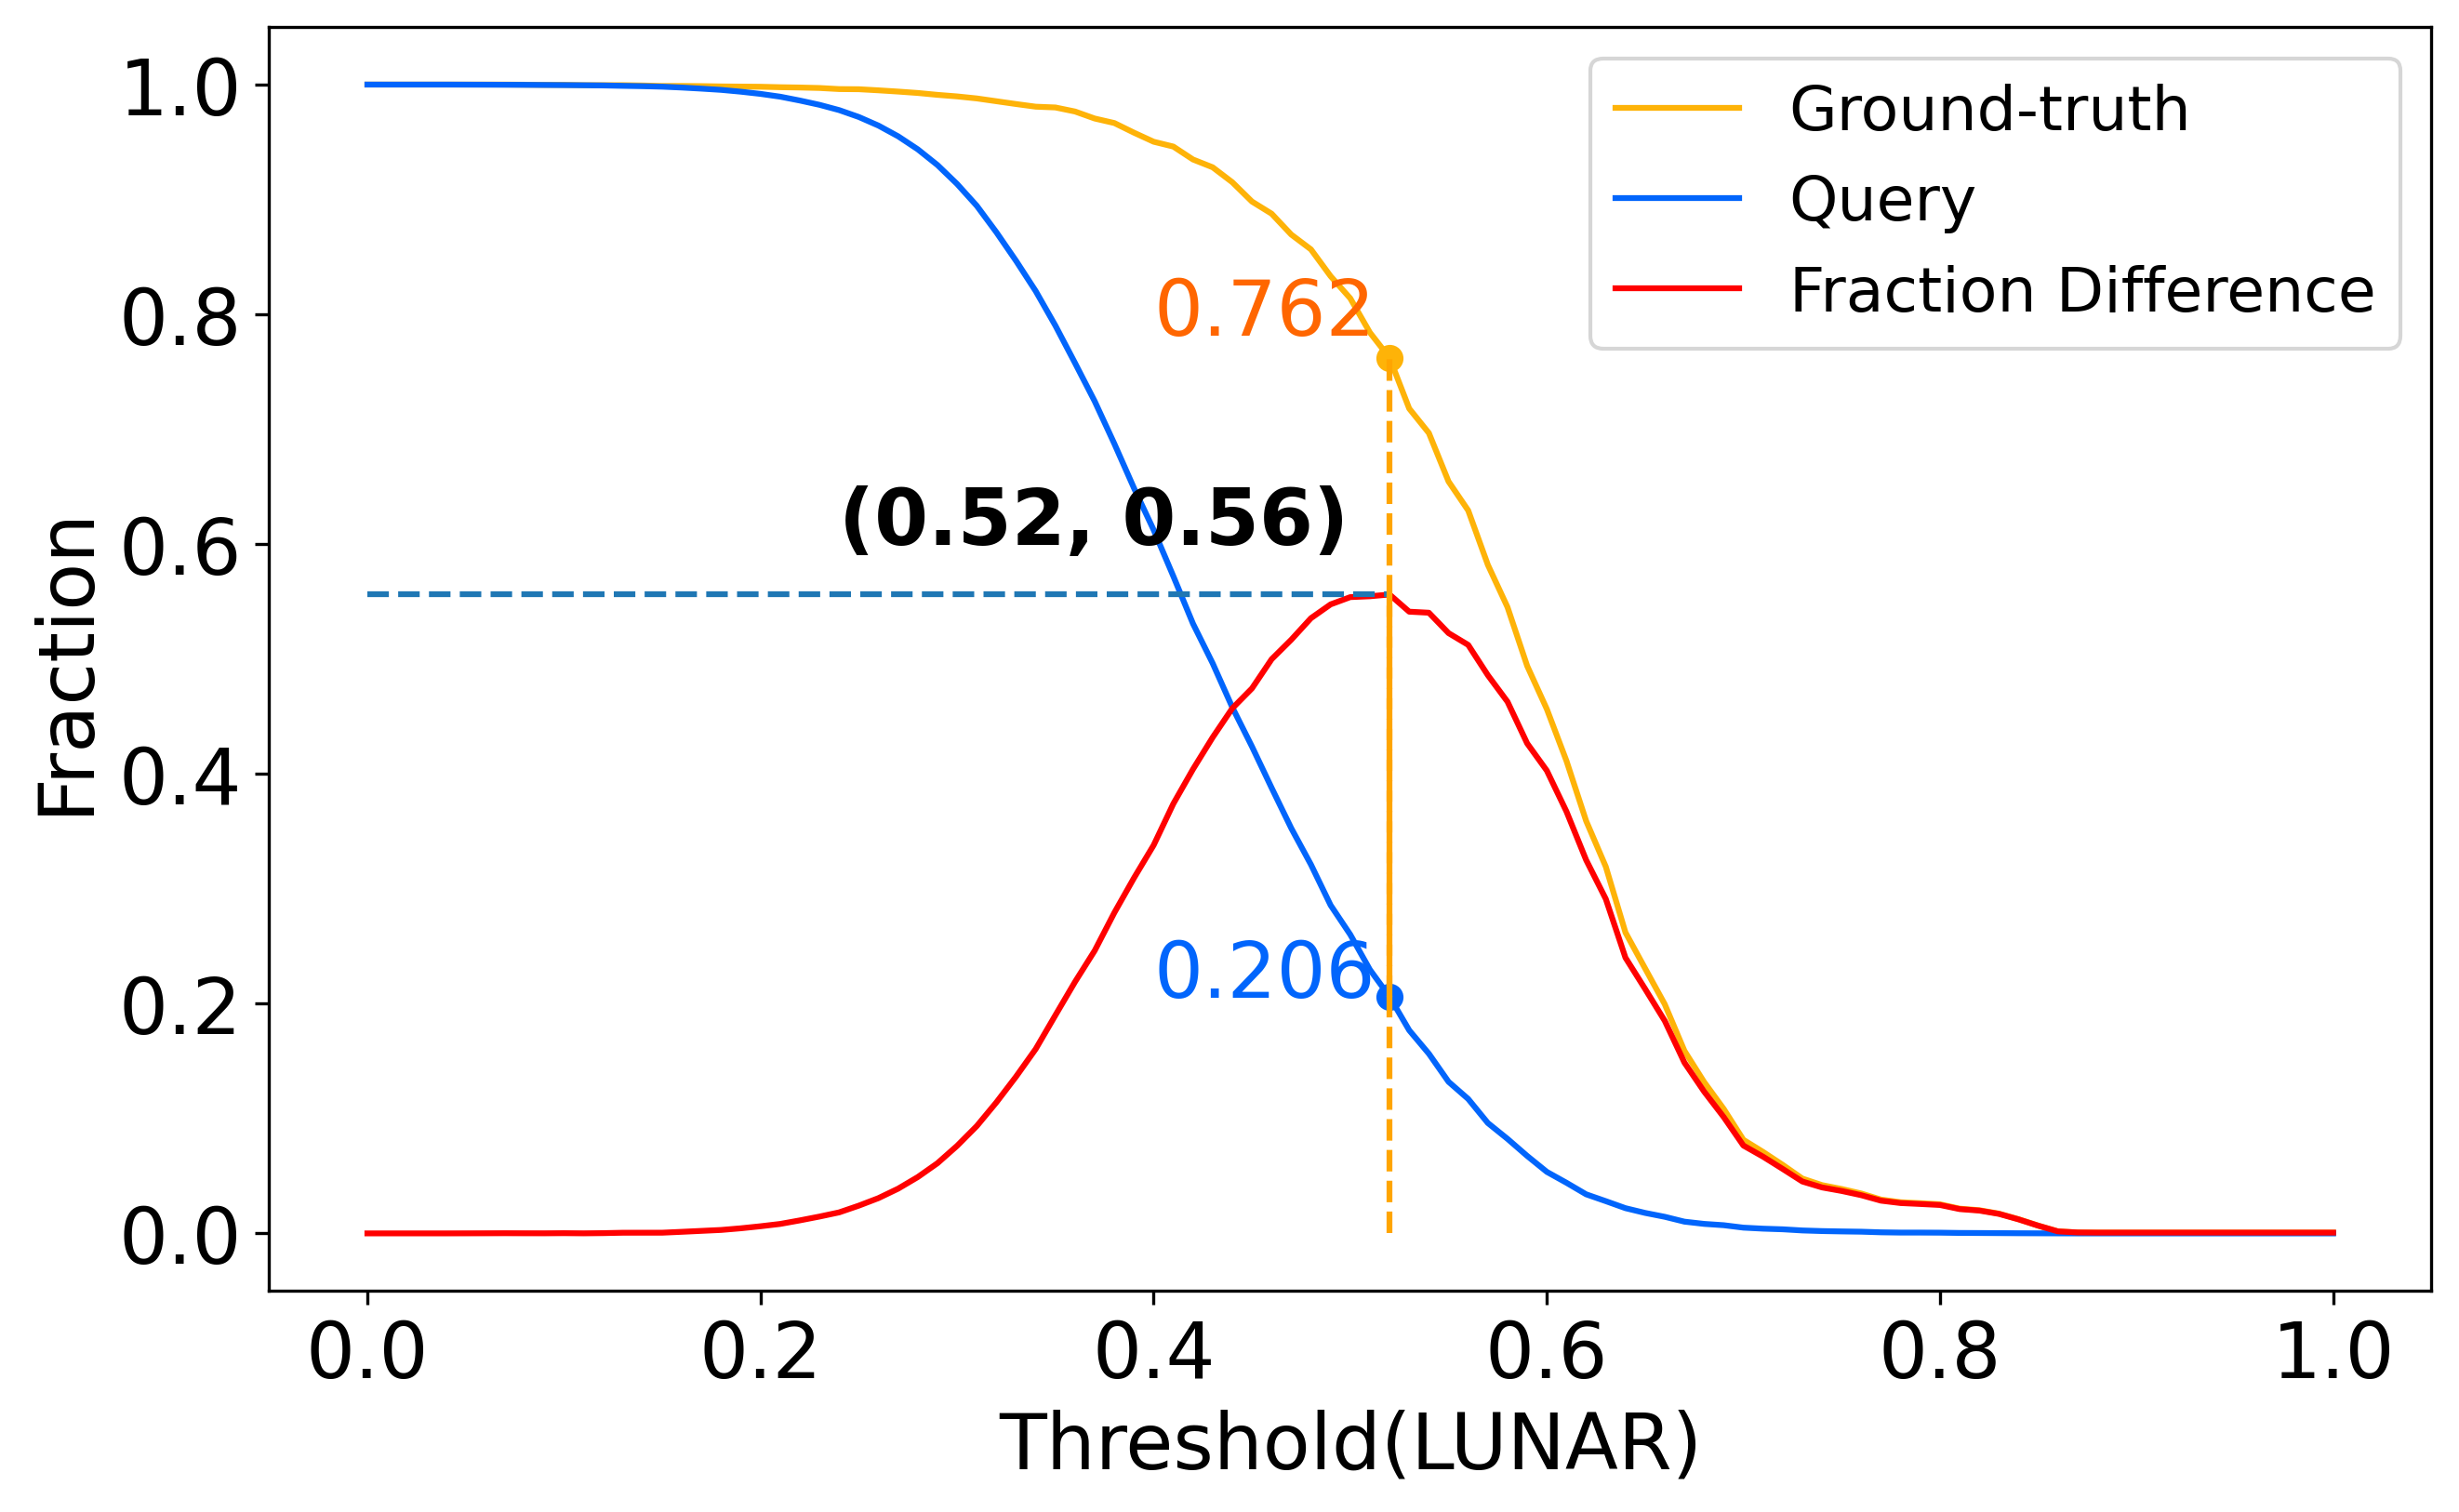

In [26]:
#plot positive fraction distributions
%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,6),dpi=300)

for i in np.arange(1):
    
    #score normalisation
    scores_range = np.concatenate((train_result.iloc[:,i],test_result.iloc[:,i])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_result.iloc[:,i]).reshape(-1,1)) 
    test_scores = scores_scaler.transform(np.array(test_result.iloc[:,i]).reshape(-1,1))
    
    ax = plt.subplot(1,1,i+1)
    fontsize = 20
    
    #set 100 thresholds between [0,1]
    iter_num = np.linspace(0.0,1.0,num=101)
    train_fraction = []
    test_fraction = []
    single_eval = []
    
    for i in iter_num:
        threshold = i
        train_count_inlier = np.sum(train_scores >= threshold)
        test_count_inlier = np.sum(test_scores[:] >= threshold)
        train_percent = train_count_inlier/7375
        test_percent = test_count_inlier/160582
        single = train_percent - test_percent
        train_fraction.append(train_percent)
        test_fraction.append(test_percent)
        single_eval.append(single)

    #plot positive fraction distributions for the ground_truth and the query dataset, and the fraction difference between these two datasets
    plt.plot(iter_num,train_fraction,color='#feb308',label='Ground-truth')
    plt.plot(iter_num,test_fraction,color='#0165fc',label='Query')
    plt.plot(iter_num,single_eval,color='red',label='Fraction Difference')
    
    #extreme point calculation and labelling
    single_max = max(single_eval)
    temp = single_eval.index(single_max)
    threshold_max = iter_num[temp]
    plt.plot([0,threshold_max],[single_max,single_max], '--')
    plt.plot([threshold_max,threshold_max],[0,single_max], '--', color='orange')
    single_max = round(single_max,2)
    threshold_max = round(threshold_max,3)
    cord =  '('+format(threshold_max, '.2f')+', '+format(single_max,'.2f')+')'
    plt.text(threshold_max-0.28, single_max+0.04, cord, fontsize=fontsize, fontweight='semibold')
    #the positive fraction for the query dataset at the extreme point
    test_max = test_fraction[temp]
    test_max = round(test_max,3)
    plt.scatter(threshold_max, test_max, c='#0165fc')
    plt.text(threshold_max-0.12, test_max, test_max, fontsize=fontsize,c='#0165fc')
    #the positive fraction for the ground_truth dataset at the extreme point
    train_max = train_fraction[temp]
    train_max = round(train_max,3)
    plt.scatter(threshold_max, train_max, c='#feb308')
    plt.text(threshold_max-0.12, train_max+0.02, train_max, fontsize=fontsize,c='#ff6600')
    #draw reference line
    refer_min, refer_max = min(train_max, test_max), max(train_max, test_max)
    plt.plot([threshold_max,threshold_max],[refer_min,refer_max], '--', color='orange')
    
    label = 'Threshold(LUNAR)'
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(label, fontsize=fontsize)
    plt.ylabel('Fraction', fontsize=fontsize)
    plt.legend(prop={'size': 16}, loc='best')
    
plt.subplots_adjust(wspace=0.14)    
plt.show()

# DeepSVDD model trained by 205 metal features and 2048-dimensional ECFPs (radius=3)

In [ ]:
#produce ECFPs features for all linkers
def morgan_fpts_dl(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = AllChem.GetMorganFingerprintAsBitVect(mol,3,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)
    return np.array(Morgan_fpts)

Morgan_fpts_dl = morgan_fpts_dl(linker_list)
linker_df = pd.DataFrame(Morgan_fpts_dl, index=linker_list, columns=['Col_{}'.format(i) for i in range(Morgan_fpts_dl.shape[1])])

In [91]:
#import 205 metal features
metal_minmax = pd.read_csv('../dataset_generation_and_featurization/metal_scaled_205.csv',index_col=0)
linker_minmax = linker_df

train_result=pd.DataFrame()
test_result=pd.DataFrame()

#import the DeepSVDD model
import sys
paths = ['../models/Deep-SVDD-PyTorch/', '../models/Deep-SVDD-PyTorch/src', '../models/set_transformer/']
sys.path.extend(paths)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from modules import SAB, PMA, ISAB
import tqdm
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
import deepSVDD
from base.base_net import BaseNet

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

#generate full data vector
#the ground_truth dataset
metal_data= list()
for metal in labelled_pairs['metal']:
    metal_data.append(metal_minmax.loc[metal,:])    
metal_data = pd.DataFrame(metal_data, index=np.arange(len(labelled_pairs['metal'])), columns = metal_minmax.columns.values)
linker_data= list()
for linker in labelled_pairs['linker_SMILES']:   
    linker_data.append(linker_minmax.loc[linker,:])
linker_data = pd.DataFrame(linker_data, index=np.arange(len(labelled_pairs['metal'])), columns= linker_minmax.columns.values)
labelled_df = pd.concat([labelled_pairs, metal_data, linker_data], axis = 1)
#the query dataset
metal_data= list()
for metal in unlabelled_pairs['metal']:
    metal_data.append(metal_minmax.loc[metal,:])    
metal_data = pd.DataFrame(metal_data, index=np.arange(len(unlabelled_pairs['metal'])), columns = metal_minmax.columns.values)
linker_data= list()
for linker in unlabelled_pairs['linker_SMILES']:   
    linker_data.append(linker_minmax.loc[linker,:])
linker_data = pd.DataFrame(linker_data, index=np.arange(len(unlabelled_pairs['metal'])), columns= linker_minmax.columns.values)
unlabelled_df = pd.concat([unlabelled_pairs, metal_data, linker_data], axis = 1)

#training data and test data assignment
X_train = labelled_df.iloc[:,2:] 
X_test = unlabelled_df.iloc[:,2:]

#save the dimensionality of feature vector
INPUT_DIM = X_train.shape[1]

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        #loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        #loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()
        self.train = train

        if data is None:
          self.data = X_train.values.astype('f')
        else:
          self.data = data.values.astype('f')        
        self.labels = np.zeros(self.data.shape[0])

    #this is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    #for Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)


def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


def build_autoencoder(net_name):

    return PairsAutoEncoder()


def build_network(net_name):  

    return PairsEncoder()

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=INPUT_DIM, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=10),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))


    def forward(self, x):
      x = torch.split(x, INPUT_DIM, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()


class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential(nn.Linear(in_features=100, out_features=INPUT_DIM), nn.Sigmoid())
        self.decoder.apply(init_weights)

    def forward(self, x):

        return self.decoder(self.encoder(x))

from base.base_dataset import BaseADDataset
from torch.utils.data import DataLoader

class TorchvisionDataset(BaseADDataset):

    """TorchvisionDataset class for datasets already implemented in torchvision.datasets."""

    def __init__(self, root: str):
        super().__init__(root)
    def loaders(self, batch_size: int, shuffle_train=True, shuffle_test=False, num_workers: int = 0) -> (
            DataLoader, DataLoader):
        train_loader = DataLoader(dataset=self.train_set, batch_size=batch_size, shuffle=shuffle_train,
                                  num_workers=num_workers)
        test_loader = DataLoader(dataset=self.test_set, batch_size=batch_size, shuffle=shuffle_test,
                                 num_workers=num_workers)

        return train_loader, test_loader

cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 1e-3, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (100,), 
              'ae_n_epochs': 80, 
              'ae_lr': 1e-5,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-7,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 80, 
              'lr': 1e-5, 
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cpu', 
              'nu': 0.05, 
              'objective': 'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'mof', 'net_name': 'mof_Net'})

dataset_name = cfg.settings['dataset_name']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
torch.manual_seed(0)

deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.net = build_network(net_name)
deep_SVDD.ae_net = build_autoencoder(net_name)
deep_SVDD.net_name = net_name
device = 'cpu'

dataset = Pairs_Dataset('')

#pretraining process
deep_SVDD.pretrain(dataset,
                   optimizer_name = cfg.settings['ae_optimizer_name'],
                   lr = cfg.settings['ae_lr'],
                   n_epochs = cfg.settings['ae_n_epochs'],
                   lr_milestones  =cfg.settings['ae_lr_milestone'],
                   batch_size = cfg.settings['ae_batch_size'], 
                   weight_decay = cfg.settings['ae_weight_decay'],  
                   device = device,
                   n_jobs_dataloader = 0)

#training process
deep_SVDD.train(dataset,
                optimizer_name = cfg.settings['optimizer_name'],
                lr = cfg.settings['lr'],
                n_epochs = cfg.settings['n_epochs'],
                lr_milestones = cfg.settings['lr_milestone'],
                batch_size = cfg.settings['batch_size'],
                weight_decay = cfg.settings['weight_decay'],
                device = device,
                n_jobs_dataloader = n_jobs_dataloader)    

#function of anomally score calculation
def score(deep_SVDD, X):

    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist

    return scores


lab = score(deep_SVDD, X_train.values).cpu().detach().numpy()*-1 
unlab = score(deep_SVDD, X_test.values).cpu().detach().numpy()*-1

train_result.insert(train_result.shape[1], column=str(INPUT_DIM), value=lab)
test_result.insert(test_result.shape[1], column=str(INPUT_DIM), value=unlab)  

C:\ANACONDA3\2021.05\envs\py37\lib\site-packages\ipykernel_launcher.py:115: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
INFO:root:Starting pretraining...
C:\ANACONDA3\2021.05\envs\py37\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/80	 Time: 7.431	 Loss: 530.80974599
INFO:root:  Epoch 2/80	 Time: 8.308	 Loss: 494.96686038
INFO:root:  Epoch 3/80	 Time: 7.760	 Loss: 447.98031534
INFO:root:  Epoch 4/80	 Time: 7.261	 Loss: 379.52263250
INFO:root:  Ep

INFO:root:  Epoch 50/80	 Time: 6.959	 Loss: 0.00242910
C:\ANACONDA3\2021.05\envs\py37\lib\site-packages\torch\optim\lr_scheduler.py:419: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
INFO:root:  LR scheduler: new learning rate is 1e-06
INFO:root:  Epoch 51/80	 Time: 6.694	 Loss: 0.00241459
INFO:root:  Epoch 52/80	 Time: 7.056	 Loss: 0.00240461
INFO:root:  Epoch 53/80	 Time: 6.735	 Loss: 0.00239527
INFO:root:  Epoch 54/80	 Time: 7.032	 Loss: 0.00238652
INFO:root:  Epoch 55/80	 Time: 6.773	 Loss: 0.00237723
INFO:root:  Epoch 56/80	 Time: 7.019	 Loss: 0.00237045
INFO:root:  Epoch 57/80	 Time: 6.763	 Loss: 0.00236045
INFO:root:  Epoch 58/80	 Time: 6.727	 Loss: 0.00235114
INFO:root:  Epoch 59/80	 Time: 7.039	 Loss: 0.00234269
INFO:root:  Epoch 60/80	 Time: 6.731	 Loss: 0.00233279
INFO:root:  Epoch 61/80	 Time: 6.981	 Loss: 0.00232358
INFO:root:  Epoch 62/80	 Time: 6.843	 Loss: 0.00231431
INFO:r

In [93]:
#save results
train_result.to_csv('DeepSVDD_train.csv')
test_result.to_csv('DeepSVDD_test.csv')

In [15]:
#read results
train_result = pd.read_csv('DeepSVDD_train.csv', index_col=0)
test_result = pd.read_csv('DeepSVDD_test.csv', index_col=0)

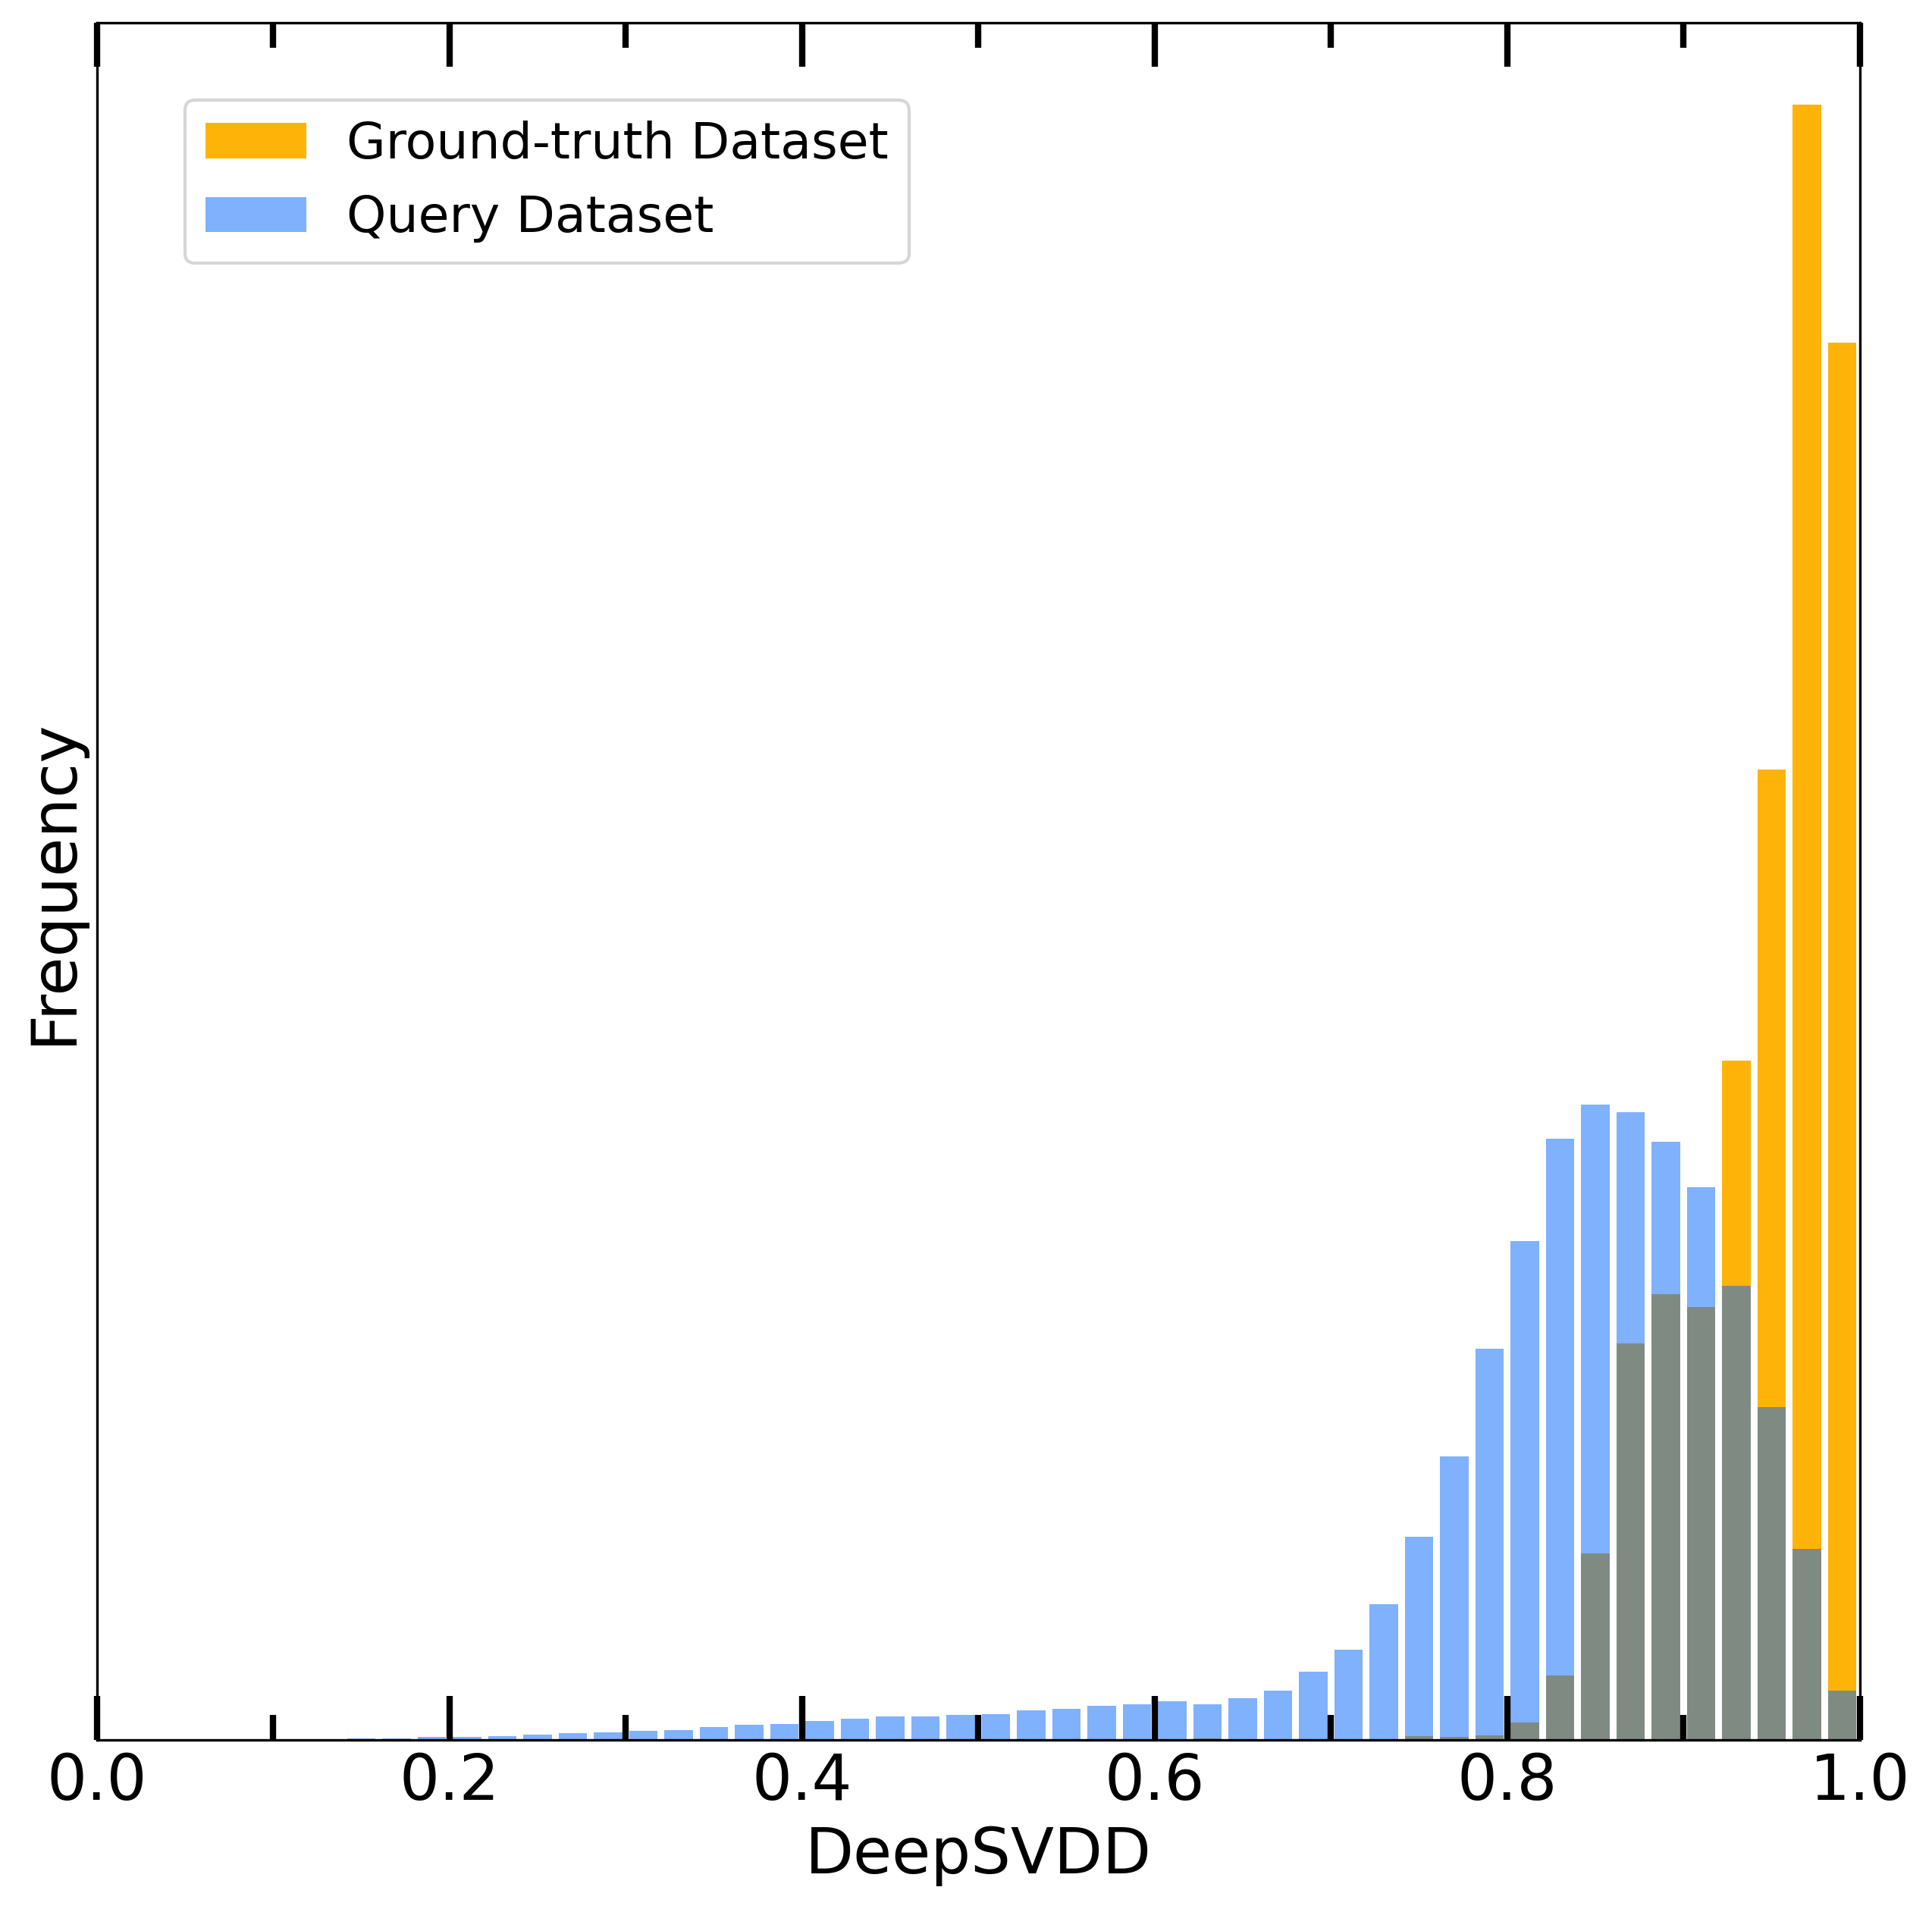

In [31]:
#plot score distributions
MinMax_scaler = preprocessing.MinMaxScaler()

%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,10),dpi=300)

for i in np.arange(1):
    
    scores_range = np.concatenate((train_result.iloc[:,i],test_result.iloc[:,i])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_result.iloc[:,i]).reshape(-1,1)) 
    test_scores = scores_scaler.transform(np.array(test_result.iloc[:,i]).reshape(-1,1))
    scores_bins = scores_scaler.transform(scores_range)
    
    ax = plt.subplot(1,1,i+1)
    _, bins , _ = plt.hist(scores_bins, bins=50, density=True, rwidth=0, alpha=0)
    plt.hist(train_scores, bins=bins, rwidth=0.8, histtype='bar', density=True, alpha=1, color='#feb308', label='Ground-truth Dataset')
    _= plt.hist(test_scores[:], bins=bins, density=True, rwidth=0.8, alpha=0.5, color='#0165fc', label='Query Dataset')
    #_ = plt.axvline(x=threshold, label='Threshold',linestyle='--', c='r', linewidth=3) # threshold line   

    plt.grid(False)
    plt.xlim(0, 1.0)
    plt.xlabel('DeepSVDD', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks([])
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    major_ticks_x = np.arange(0, 1.001, 0.2)
    minor_ticks_x = np.arange(0,1.001, 0.1)
    ax.tick_params(axis = 'both', which='both', width=2)
    ax.tick_params(axis = 'both', which='major', length=14)
    ax.tick_params(axis = 'both', which='minor', length=8, color='black')
    ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)

    plt.legend(prop={'size': 16}, loc=[0.05, 0.86])
   
plt.subplots_adjust(wspace=0.1)
plt.show()  

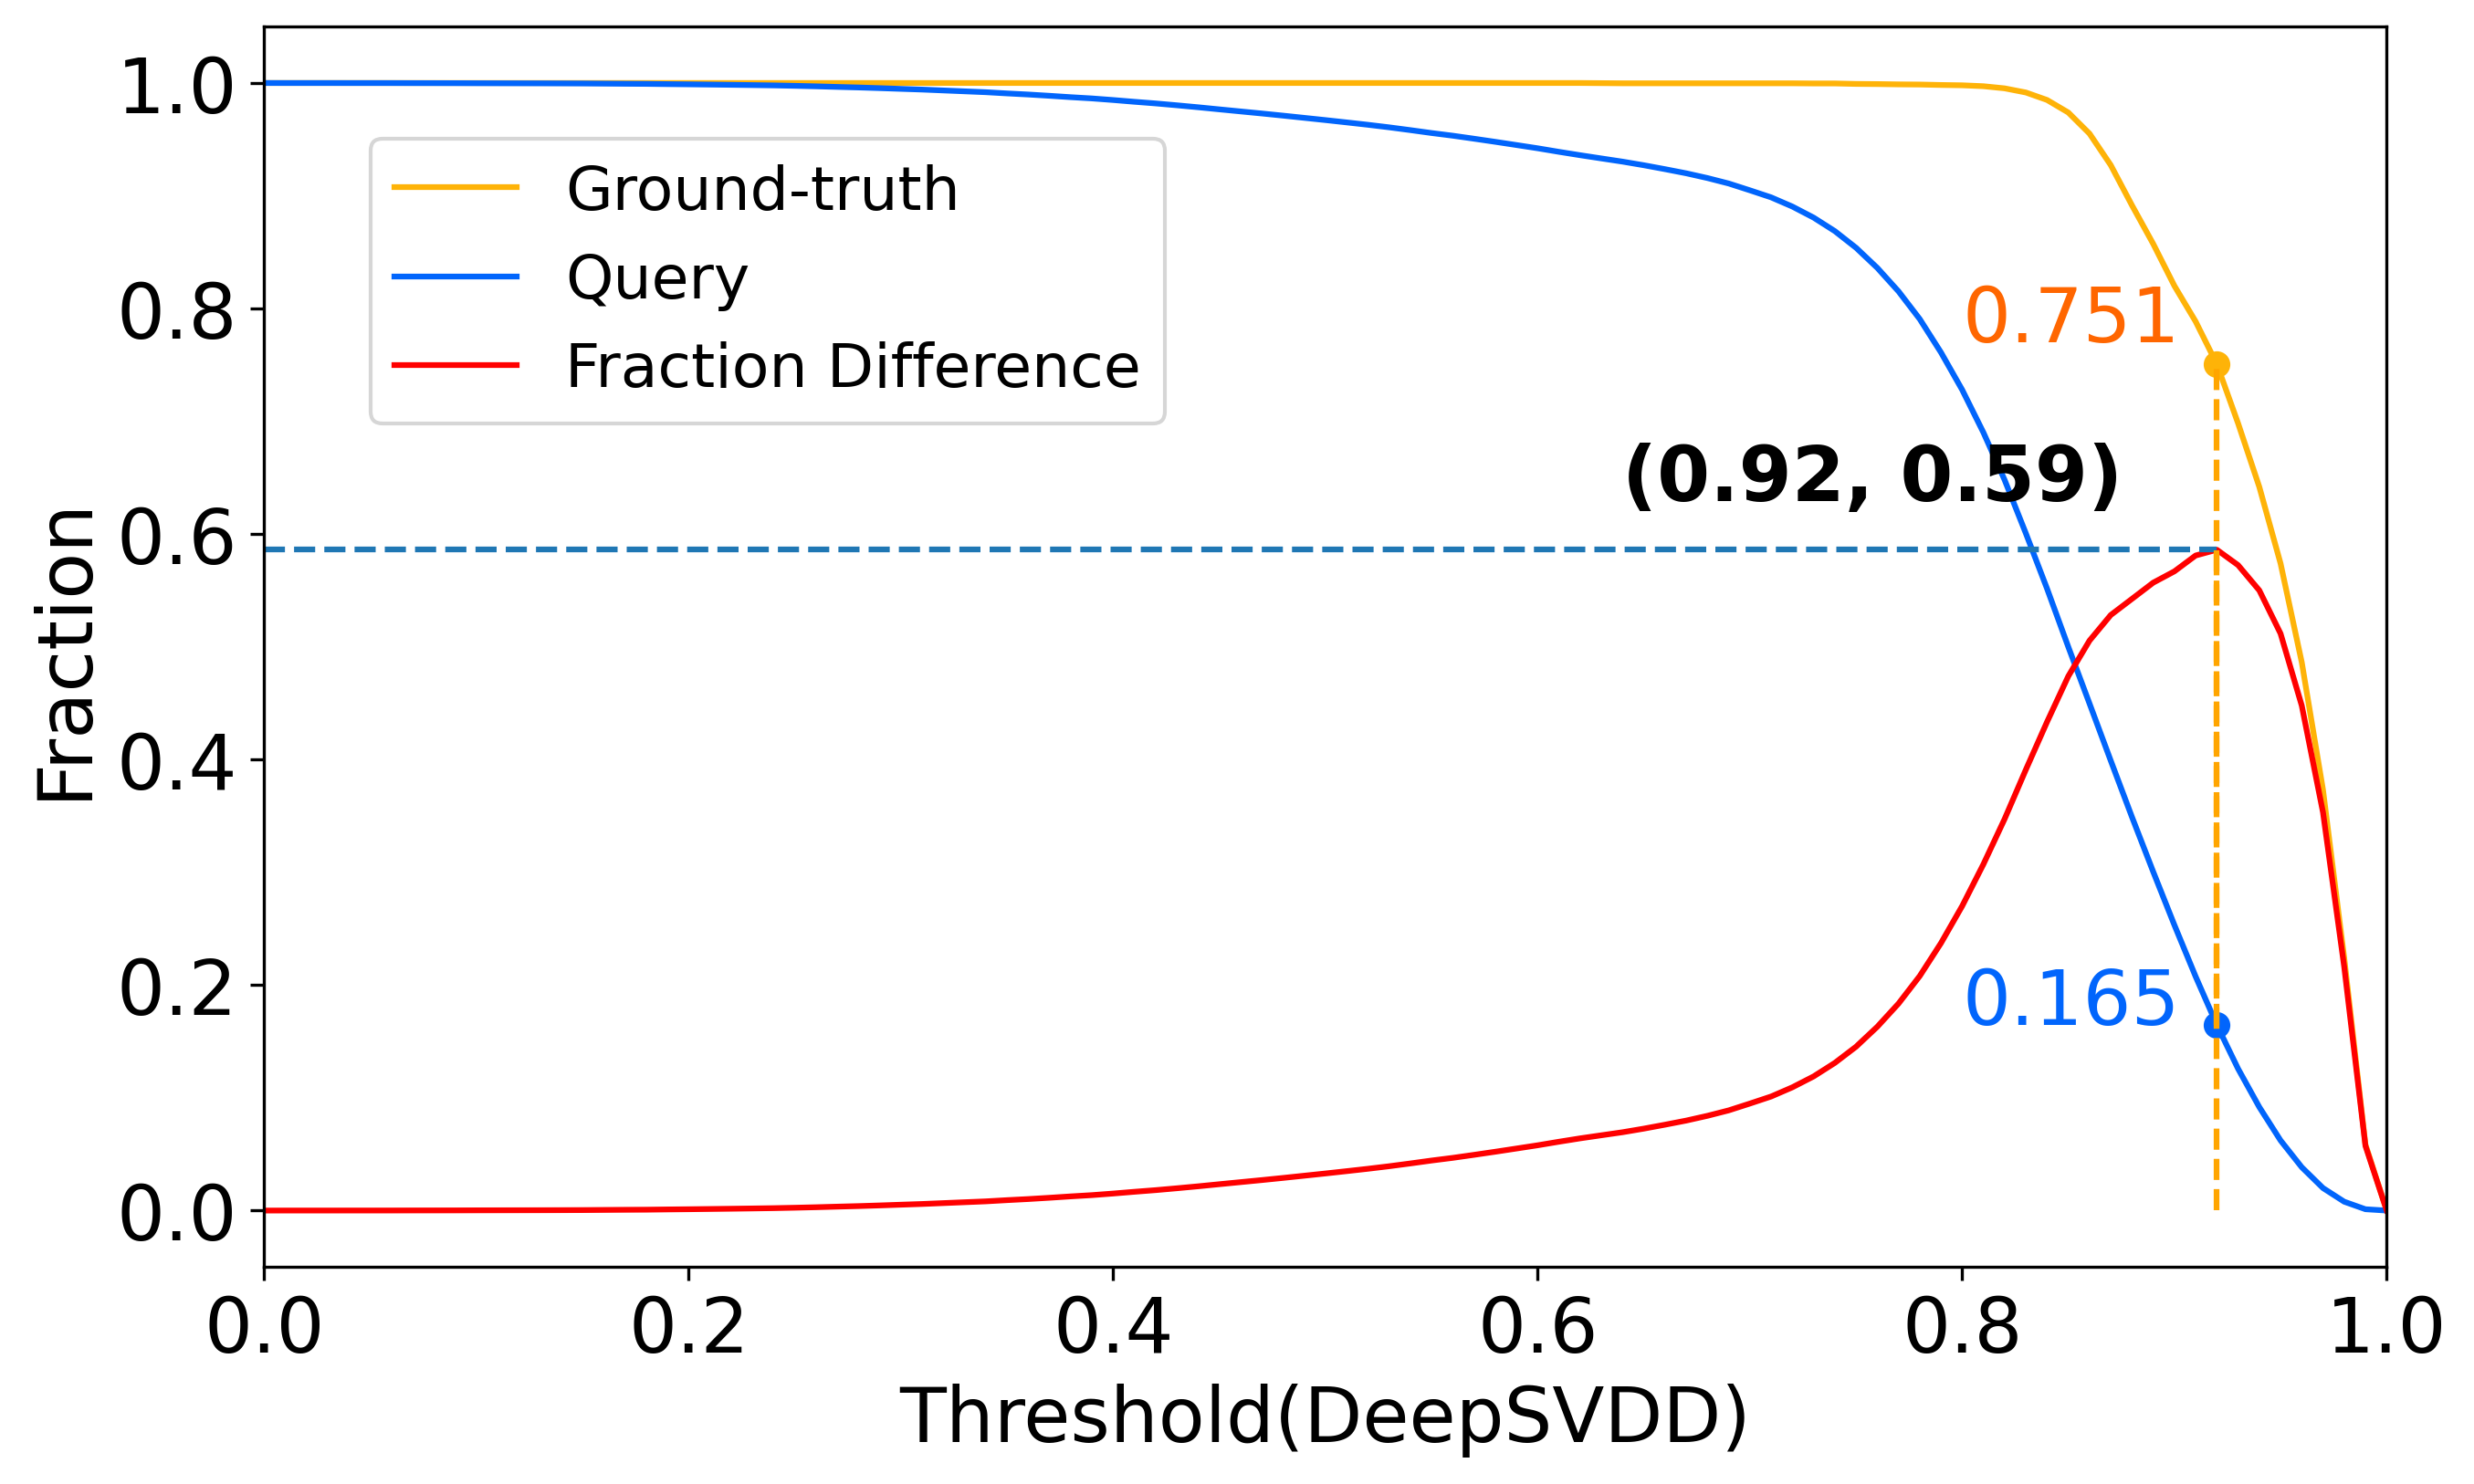

In [33]:
#plot positive fraction distributions
%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,6),dpi=300)

for i in np.arange(1):
    
    scores_range = np.concatenate((train_result.iloc[:,i],test_result.iloc[:,i])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_result.iloc[:,i]).reshape(-1,1)) 
    test_scores = scores_scaler.transform(np.array(test_result.iloc[:,i]).reshape(-1,1))
    
    ax = plt.subplot(1,1,i+1)
    fontsize = 20
    
    iter_num = np.linspace(0.0,1.0,num=101)
    train_fraction = []
    test_fraction = []
    single_eval = []
    
    for i in iter_num:
        threshold = i
        train_count_inlier = np.sum(train_scores >= threshold)
        test_count_inlier = np.sum(test_scores[:] >= threshold)
        train_percent = train_count_inlier/7375
        test_percent = test_count_inlier/160582
        single = train_percent - test_percent
        train_fraction.append(train_percent)
        test_fraction.append(test_percent)
        single_eval.append(single)

    #plot curves
    plt.plot(iter_num,train_fraction,color='#feb308',label='Ground-truth')
    plt.plot(iter_num,test_fraction,color='#0165fc',label='Query')
    plt.plot(iter_num,single_eval,color='red',label='Fraction Difference')
    
    #extreme point calculation and labelling
    single_max = max(single_eval)
    temp = single_eval.index(single_max)
    threshold_max = iter_num[temp]
    plt.plot([0,threshold_max],[single_max,single_max], '--')
    plt.plot([threshold_max,threshold_max],[0,single_max], '--', color='orange')
    single_max = round(single_max,2)
    threshold_max = round(threshold_max,3)
    cord =  '('+format(threshold_max, '.2f')+', '+format(single_max,'.2f')+')'
    plt.text(threshold_max-0.28, single_max+0.04, cord, fontsize=fontsize, fontweight='semibold')
    #the positive fraction for the query dataset at the extreme point
    test_max = test_fraction[temp]
    test_max = round(test_max,3)
    plt.scatter(threshold_max, test_max, c='#0165fc')
    plt.text(threshold_max-0.12, test_max, test_max, fontsize=fontsize,c='#0165fc')
    #the positive fraction for the ground_truth dataset at the extreme point
    train_max = train_fraction[temp]
    train_max = round(train_max,3)
    plt.scatter(threshold_max, train_max, c='#feb308')
    plt.text(threshold_max-0.12, train_max+0.02, train_max, fontsize=fontsize,c='#ff6600')
    #draw reference line
    refer_min, refer_max = min(train_max, test_max), max(train_max, test_max)
    plt.plot([threshold_max,threshold_max],[refer_min,refer_max], '--', color='orange')
    
    label = 'Threshold(DeepSVDD)'
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(label, fontsize=fontsize)
    plt.ylabel('Fraction', fontsize=fontsize)
    plt.legend(prop={'size': 16}, loc=[0.05, 0.68])
    plt.xlim(0, 1.0)
    
plt.subplots_adjust(wspace=0.14)    
plt.show()